## One cycle CIFAR10


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#PyTorch stuff
import torch
torch.manual_seed(0)
from torch import optim, nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split

### GPU

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


###  Datasets y Dataloaders

In [3]:
switch = int(input('Are you in the Mac or in the PC? Use 1 to indicate you are using Mac', ))

if switch == 1:
    
    trainPath = '/Users/fervargas/Developer/py/cnn/chest_xray/train'
    testPath = '/Users/fervargas/Developer/py/cnn/chest_xray/test'
    ValidationPath = '/Users/fervargas/Developer/py/cnn/chest_xray/val' 
else:
    trainPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/train"
    testPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/test"
    ValidationPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/val"
transform = T.Compose([
        T.Resize([224,224]),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# Crear data sets para los entrenamientos, la validacion y las pruebas
trainDS = datasets.ImageFolder(trainPath, transform=transform)
valDS = datasets.ImageFolder(ValidationPath, transform=transform)
testDS = datasets.ImageFolder(testPath, transform=transform)

batchSize = 64

trainLoader = DataLoader(dataset=trainDS, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(dataset=valDS, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(dataset=testDS, batch_size=batchSize, shuffle=True)

In [4]:
for i, (x, y) in enumerate(valLoader):
    print(i, x.shape, y.shape)

0 torch.Size([16, 3, 224, 224]) torch.Size([16])


### Mostrar datos

La imagen representa: NORMAL


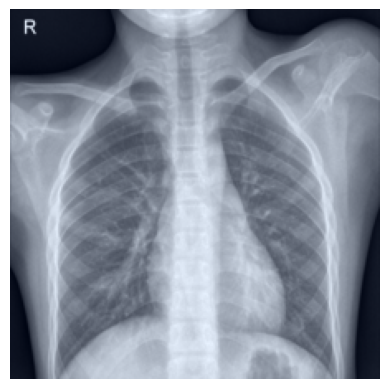

In [5]:
categorias = ['NORMAL', 'PNEUMONIA']

def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

sample_id = np.random.randint(int(len(testLoader)))
print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)

#### Accuracy

In [6]:
len(valLoader)

1

In [7]:
def accuracy(model, loader):
    '''
    model - PyTorch model
    loader - PyTorch dataloader
    
    Returns:
    
    '''
    correct = 0
    total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, pred = scores.max(dim=1)
            correct += (pred == y).sum()
            total += pred.size(0)
        return cost/len(loader), float(correct)/total

#### Buscar learning rate

In [8]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = trainLoader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0)) 
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
        
#         accuracies.append(acc.item())
        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies     

### Loop de Entrenamiento

In [9]:
def train(model, optimiser, scheduler = None, epochs = 100):
    model = model.to(device = device)
    val_loss_history = []
    train_loss_history = []
    val_acc_history = []
    train_acc_history = []
    lrs = []
    train_cost = 0.
    val_cost = 0.
    train_cost_acum = 0
    for epoch in range(epochs):
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x, y) in enumerate(trainLoader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            #if using scheduler
            if scheduler: scheduler.step()
                
            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)        
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num)/train_total  
#             train_cost = train_cost_acum/mb
            val_cost, val_acc = accuracy(model, valLoader)

            val_loss_history.append(val_cost)
            train_loss_history.append(cost.item())
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
#             lrs.append(scheduler.get_last_lr()[0])
            lrs.append(optimiser.param_groups[0]["lr"])
        
        #f'last lr: {scheduler.get_last_lr()[0]:6f},
        
        train_acc = float(train_correct_num)/train_total
        train_cost = train_cost_acum/len(trainLoader)
        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f}, total: {train_total},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')
        
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs

### ResNet56

In [10]:
conv_k_3 = lambda channel1, channel2, stride: nn.Conv2d(channel1, channel2, stride = stride, kernel_size=3, padding=1)

In [11]:
class residual_block(nn.Module):
    '''

    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size = True):
        super().__init__()
        self.conv1 = conv_k_3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k_3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        #for changing activation map sizes
        self.change_size = change_size
        if change_size:
            self.residual = nn.Sequential(nn.Conv2d(in_channel, 
                                                    out_channel, 
                                                    kernel_size=1,
                                                    stride=stride),
                                         nn.BatchNorm2d(out_channel)
                                         )      
    def forward(self, x):
        identity = x if not self.change_size else self.residual(x)
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        y += identity
        return F.relu(y)


In [12]:
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        self.conv1 = conv_k_3(3, 16, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = self.create_block(n=9, in_channel=16, 
                                        out_channel=16, stride=1, 
                                        change_size=False)
        self.block2 = self.create_block(n=9, in_channel=16, 
                                        out_channel=32, stride=2)
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        self.fc = nn.Linear(64, num_classes)

    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))
        return nn.Sequential(*block)   
        
    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.block3(self.block2(self.block1(y)))
        y = F.adaptive_avg_pool2d(y, 1)
        return self.fc(y.view(y.size(0), -1))      
       
        

In [13]:
model_resnet56 = ResNet56()

In [14]:
# model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)

In [15]:
lg_lr, losses, accuracies = find_lr(model_resnet56, optimiser_resnet56,
                                    start_val=1e-6, end_val=10)

cost:2.7391, lr: 0.0000, acc: 0.0000
cost:2.9235, lr: 0.0000, acc: 0.0000
cost:2.7791, lr: 0.0000, acc: 0.0000
cost:2.7357, lr: 0.0000, acc: 0.0000
cost:3.0203, lr: 0.0000, acc: 0.0000
cost:2.8583, lr: 0.0000, acc: 0.0000
cost:2.8619, lr: 0.0000, acc: 0.0000
cost:2.9688, lr: 0.0000, acc: 0.0000
cost:2.7632, lr: 0.0000, acc: 0.0000
cost:2.7554, lr: 0.0000, acc: 0.0000
cost:2.7539, lr: 0.0000, acc: 0.0000
cost:2.7440, lr: 0.0000, acc: 0.0000
cost:2.7904, lr: 0.0000, acc: 0.0000
cost:2.7528, lr: 0.0000, acc: 0.0000
cost:2.7802, lr: 0.0000, acc: 0.0000
cost:2.6873, lr: 0.0000, acc: 0.0000
cost:2.7226, lr: 0.0000, acc: 0.0000
cost:2.7080, lr: 0.0000, acc: 0.0000
cost:2.6431, lr: 0.0000, acc: 0.0000
cost:2.6462, lr: 0.0000, acc: 0.0000
cost:2.5035, lr: 0.0001, acc: 0.0000
cost:2.2624, lr: 0.0001, acc: 0.0000
cost:2.3362, lr: 0.0001, acc: 0.0469
cost:2.1222, lr: 0.0001, acc: 0.1562
cost:1.9610, lr: 0.0001, acc: 0.3125
cost:1.8406, lr: 0.0001, acc: 0.3125
cost:1.7888, lr: 0.0002, acc: 0.2656
c

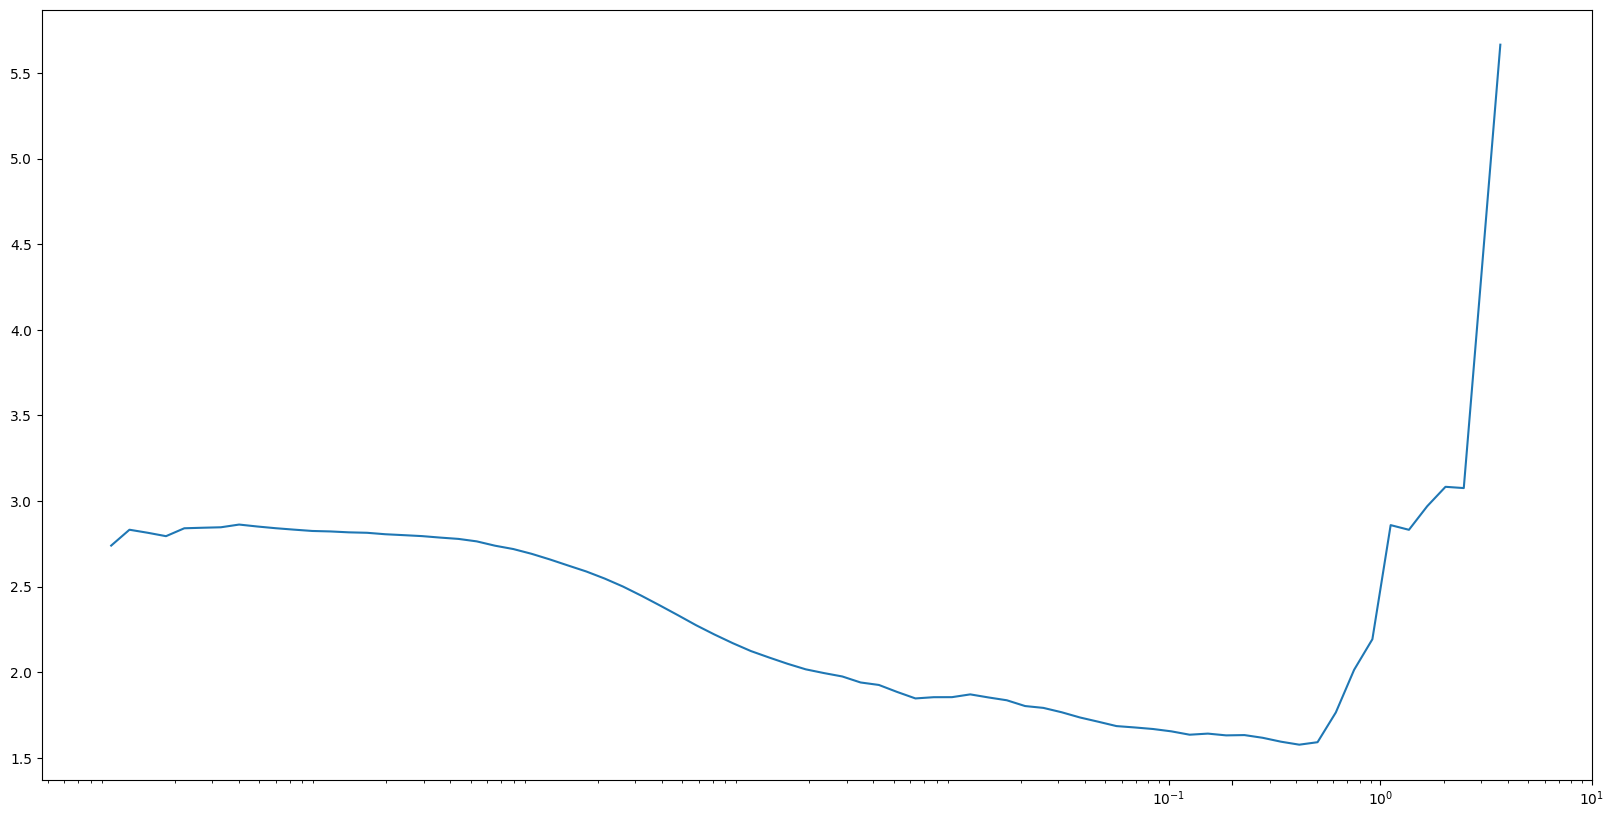

In [16]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

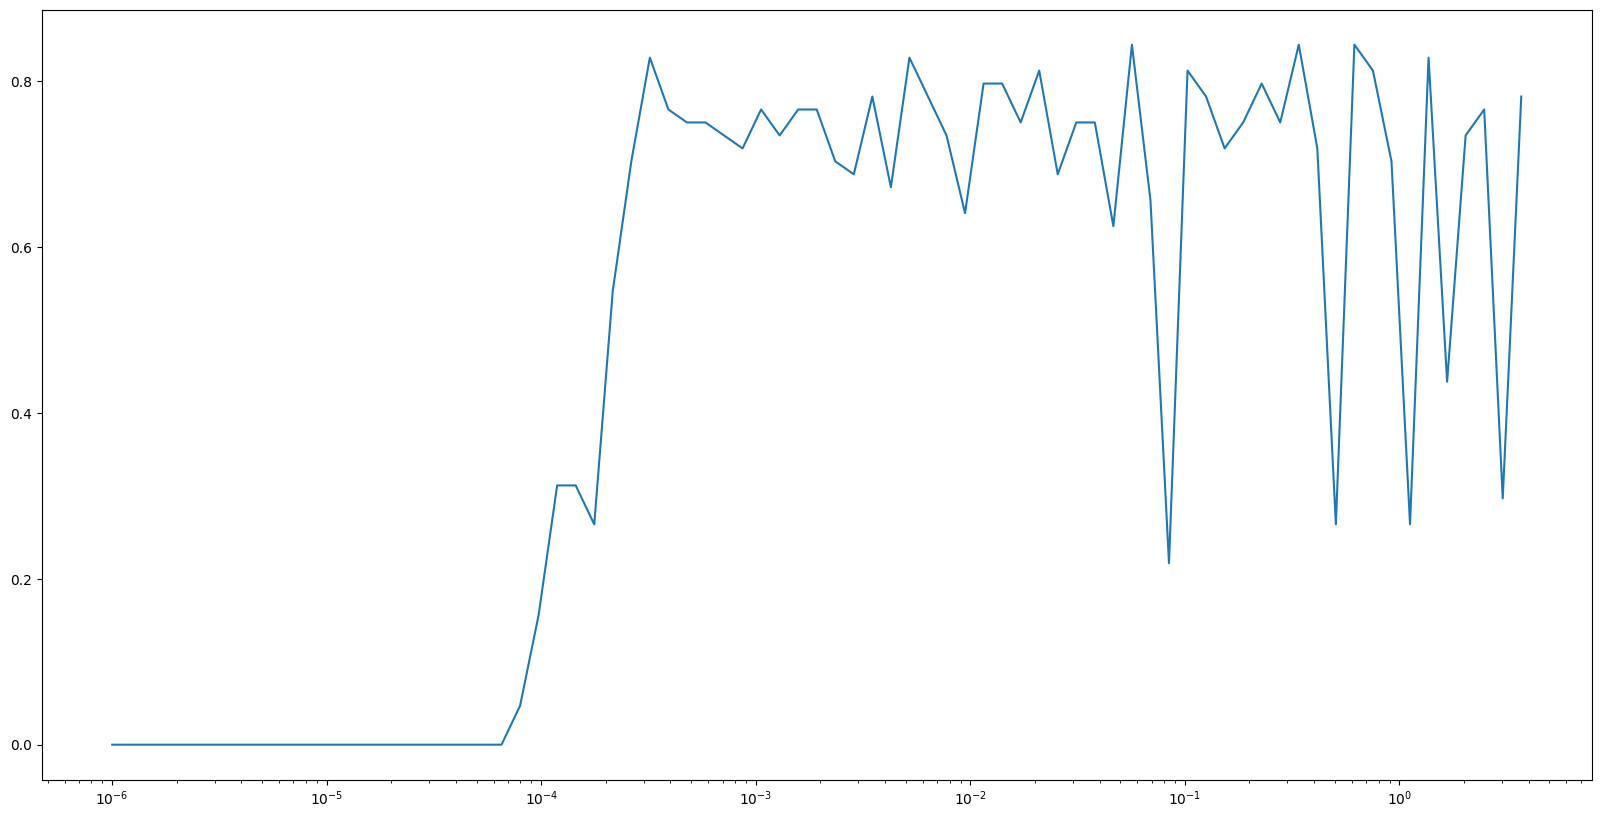

In [17]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, accuracies)
ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [18]:
model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)
epochs = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_resnet56, 
                                                max_lr=1e-2, 
                                                steps_per_epoch=len(trainLoader), 
                                                epochs = epochs, pct_start=0.43, 
                                                div_factor=10, 
                                                final_div_factor=1000, 
                                                three_phase=True, verbose=False
                                            )
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_resnet56, 
                                optimiser=optimiser_resnet56,
                                scheduler=scheduler,
                                epochs = epochs
                                )

Epoch:0, train cost: 0.450099, val cost: 1.470004, train acc: 0.8181, val acc: 0.500000, total: 5216, lr: 0.001048
Epoch:1, train cost: 0.199523, val cost: 0.795055, train acc: 0.9218, val acc: 0.750000, total: 5216, lr: 0.001191
Epoch:2, train cost: 0.160800, val cost: 0.932889, train acc: 0.9388, val acc: 0.625000, total: 5216, lr: 0.001426
Epoch:3, train cost: 0.127208, val cost: 1.635412, train acc: 0.9546, val acc: 0.500000, total: 5216, lr: 0.001748
Epoch:4, train cost: 0.110699, val cost: 3.267419, train acc: 0.9559, val acc: 0.500000, total: 5216, lr: 0.002150
Epoch:5, train cost: 0.117441, val cost: 3.502466, train acc: 0.9563, val acc: 0.500000, total: 5216, lr: 0.002623
Epoch:6, train cost: 0.109684, val cost: 0.925080, train acc: 0.9599, val acc: 0.562500, total: 5216, lr: 0.003158
Epoch:7, train cost: 0.098911, val cost: 2.157502, train acc: 0.9613, val acc: 0.500000, total: 5216, lr: 0.003743
Epoch:8, train cost: 0.092371, val cost: 0.899395, train acc: 0.9678, val acc: 0

In [ ]:
accuracy(model_resnet56, testLoader)